# Analysis & Plot the Asphalt Binder HTPG Test

This notebook includes the codes for plotting and statistical analysis on the results of High-Temperature Performance Grade (HTPG) test on different recovered and tank binders used in the PTF lanes. 

Author: Farhad Abdollahi (farhad.abdollahi.ctr@dot.gov) 

Date: 05/19/2025

___

In [15]:
# Importing the required libraries. 
import os
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scripts.Statistical_Analysis import Tukey_Grouping
from scipy.stats import ttest_ind, t

In [16]:
# User input variables. 
MainDataFileName = './data/Data.xlsx'
OutputDir        = '../_Figures'

_______


In [17]:
# Read the HTPG results. 
HTPG = pd.read_excel(MainDataFileName, sheet_name='HTPG', usecols='A:F', skiprows=1, 
                     names=['Lane', 'Field_Aging', 'Lab_Aging', 'ID', 'RepNum', 'HTPG'])
HTPG.head()

,Lane,Field_Aging,Lab_Aging,ID,RepNum,HTPG
0,1,0-Month,NaN,7196,1,81.7
1,1,0-Month,NaN,7196,2,81.9
2,1,0-Month,NaN,7196,3,83.0
3,2,0-Month,NaN,7197,1,79.8
4,2,0-Month,NaN,7197,2,80.0


In [18]:
# Create a new dictionary for the analyzed results. 
HTPGRes = {'Lane': [], 'Field_Aging': [], 'HTPG_Mean': [], 'HTPG_Std': [], 'Num_Data': [], 'HTPG_Values': []}
# Calculate the average and std of the measurements. 
for ln in HTPG['Lane'].unique():            # Iterate over different lanes. 
    HTPG_L = HTPG[HTPG['Lane'] == ln]
    for age in HTPG_L['Field_Aging'].unique():      # Iterate over the field aging (tank binder or 0-month recovered binder)
        HTPG_LF = HTPG_L[HTPG_L['Field_Aging'] == age]
        if age == 'Tank binder':    # For the tank binders, need to calculate HTPG based on minimum of Unaged and RTFO-aged levels. 
            Values_Unaged = HTPG_LF[HTPG_LF['Lab_Aging'] == 'Unaged']['HTPG'].to_numpy()
            Values_RTFO   = HTPG_LF[HTPG_LF['Lab_Aging'] == 'RTFO']['HTPG'].to_numpy()
            if Values_Unaged.mean() < Values_RTFO.mean():
                Values = Values_Unaged.copy()
            else:
                Values = Values_RTFO.copy()
        else:                       # For the recovered binder, only have one aging level. 
            Values  = HTPG_LF['HTPG'].to_numpy()
        # Calculate the mean and std. 
        Mean    = Values.mean()
        Std     = Values.std()
        # Store the results. 
        HTPGRes['Lane'].append(ln)
        HTPGRes['Field_Aging'].append(age)
        HTPGRes['HTPG_Mean'].append(Mean)
        HTPGRes['HTPG_Std'].append(Std)
        HTPGRes['Num_Data'].append(len(Values))
        HTPGRes['HTPG_Values'].append(','.join(map(str, np.round(Values, 1))))
# Convert the "HTPGRes" to a dataframe. 
HTPGRes = pd.DataFrame(HTPGRes)
HTPGRes = HTPGRes.sort_values(by=['Lane', 'Field_Aging'])
HTPGRes.head()

,Lane,Field_Aging,HTPG_Mean,HTPG_Std,Num_Data,HTPG_Values
0,1,0-Month,82.200000,0.571548,3,"81.7,81.9,83.0"
1,1,Tank binder,71.700000,0.200000,2,"71.5,71.9"
2,2,0-Month,80.166667,0.385861,3,"79.8,80.0,80.7"
3,2,Tank binder,68.111872,0.142407,2,"68.3,68.0"
4,3,0-Month,77.400000,0.432049,3,"77.0,77.2,78.0"


### Now plotting the same results based on the binder types. 

In this section we have grouped the binders into: (i) controls with 20% RAP, lanes 3, 6, 9, (ii) polymer modified with 20% RAP, lanes 1, 2, 4; (iii) high-RAP with 40% RAP, lanes 5, 7, 8; and (iv) No RAP lane 10. 

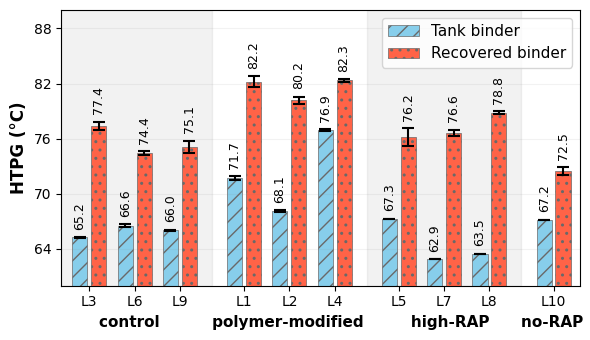

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.axvspan(xmin=-1,   xmax=7.0, color='gray', alpha=0.1)
ax.axvspan(xmin=15.2, xmax=23.4, color='gray', alpha=0.1)
XPositions = np.array([2.4 * i + j + 0.0 for i in range(0, 3) for j in range(2)] + \
                      [2.4 * i + j + 1.0 for i in range(3, 6) for j in range(2)] + \
                      [2.4 * i + j + 2.0 for i in range(6, 9) for j in range(2)] + \
                      [2.4 * i + j + 3.0 for i in range(9, 10) for j in range(2)])
ax.bar(XPositions[::2], 
       height=HTPGRes['HTPG_Mean'].to_numpy()[[5, 11, 17, 1, 3, 7, 9, 13, 15, 19]], 
       yerr=HTPGRes['HTPG_Std'].to_numpy()[[5, 11, 17, 1, 3, 7, 9, 13, 15, 19]], 
       width=0.8, edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='Tank binder',
       error_kw={'capsize': 4, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.bar(XPositions[1::2], 
       height=HTPGRes['HTPG_Mean'].to_numpy()[[4, 10, 16, 0, 2, 6, 8, 12, 14, 18]], 
       yerr=HTPGRes['HTPG_Std'].to_numpy()[[4, 10, 16, 0, 2, 6, 8, 12, 14, 18]], 
       width=0.8, edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='Recovered binder', 
       error_kw={'capsize': 4, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.set_yticks([58, 64, 70, 76, 82, 88])
ax.set_ylim([60, 90])
ax.set_xticks(XPositions[::2] + 0.5)
ax.set_xticklabels([f'L{i}' for i in [3, 6, 9, 1, 2, 4, 5, 7, 8, 10]], fontsize=10, color='k', rotation=0)
ax.set_ylabel('HTPG (°C)', fontsize=12, fontweight='bold', color='k')
ax.set_xlabel('        control          polymer-modified         high-RAP      no-RAP', 
              fontsize=11, fontweight='bold', color='k')
for i, idx in enumerate([4, 10, 16, 0, 2, 6, 8, 12, 14, 18]):
    ax.text(XPositions[2*i+1], HTPGRes['HTPG_Mean'][idx+0] + HTPGRes['HTPG_Std'][idx+0] + 0.8, 
            f'{HTPGRes["HTPG_Mean"][idx+0]:.1f}', ha='center', va='bottom', fontsize=9, rotation=90)
    ax.text(XPositions[2*i+0], HTPGRes['HTPG_Mean'][idx+1] + HTPGRes['HTPG_Std'][idx+1] + 0.8, 
            f'{HTPGRes["HTPG_Mean"][idx+1]:.1f}', ha='center', va='bottom', fontsize=9, rotation=90)
ax.set_xlim([-1.0, 26.5])
ax.grid(axis='y', color='gray', alpha=0.1)
ax.legend(fontsize=11, ncol=1, loc='upper right')
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, f'Binder_HTPG.png'), format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, f'Binder_HTPG.svg'), format='svg')

New figure including the statistical results. 

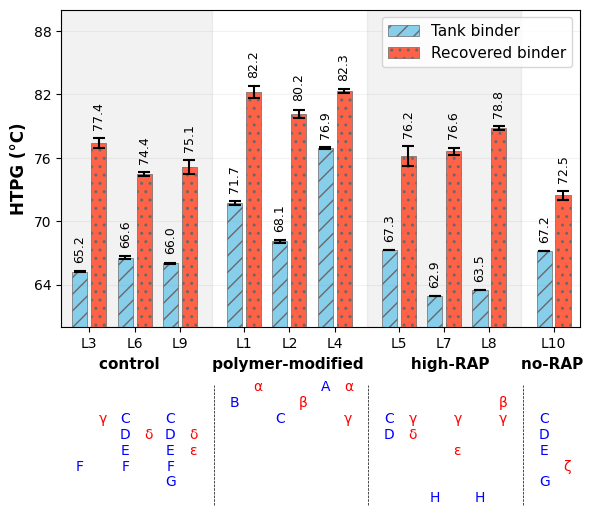

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6.0))
ax.axvspan(xmin=-1,   xmax=7.0, color='gray', alpha=0.1)
ax.axvspan(xmin=15.2, xmax=23.4, color='gray', alpha=0.1)
XPositions = np.array([2.4 * i + j + 0.0 for i in range(0, 3) for j in range(2)] + \
                      [2.4 * i + j + 1.0 for i in range(3, 6) for j in range(2)] + \
                      [2.4 * i + j + 2.0 for i in range(6, 9) for j in range(2)] + \
                      [2.4 * i + j + 3.0 for i in range(9, 10) for j in range(2)])
ax.bar(XPositions[::2], 
          height=HTPGRes['HTPG_Mean'].to_numpy()[[5, 11, 17, 1, 3, 7, 9, 13, 15, 19]], 
          yerr=HTPGRes['HTPG_Std'].to_numpy()[[5, 11, 17, 1, 3, 7, 9, 13, 15, 19]], 
          width=0.8, edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='Tank binder',
          error_kw={'capsize': 4, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.bar(XPositions[1::2], 
          height=HTPGRes['HTPG_Mean'].to_numpy()[[4, 10, 16, 0, 2, 6, 8, 12, 14, 18]], 
          yerr=HTPGRes['HTPG_Std'].to_numpy()[[4, 10, 16, 0, 2, 6, 8, 12, 14, 18]], 
          width=0.8, edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='Recovered binder', 
          error_kw={'capsize': 4, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.set_yticks([58, 64, 70, 76, 82, 88])
ax.set_ylim([60, 90])
ax.set_xticks(XPositions[::2] + 0.5)
ax.set_xticklabels([f'L{i}' for i in [3, 6, 9, 1, 2, 4, 5, 7, 8, 10]], fontsize=10, color='k', rotation=0)
ax.set_ylabel('HTPG (°C)', fontsize=12, fontweight='bold', color='k')
ax.set_xlabel('        control          polymer-modified         high-RAP      no-RAP', 
              fontsize=11, fontweight='bold', color='k')
for i, idx in enumerate([4, 10, 16, 0, 2, 6, 8, 12, 14, 18]):
    ax.text(XPositions[2*i+1], HTPGRes['HTPG_Mean'][idx+0] + HTPGRes['HTPG_Std'][idx+0] + 0.8, 
            f'{HTPGRes["HTPG_Mean"][idx+0]:.1f}', ha='center', va='bottom', fontsize=9, rotation=90)
    ax.text(XPositions[2*i+0], HTPGRes['HTPG_Mean'][idx+1] + HTPGRes['HTPG_Std'][idx+1] + 0.8, 
            f'{HTPGRes["HTPG_Mean"][idx+1]:.1f}', ha='center', va='bottom', fontsize=9, rotation=90)
ax.set_xlim([-1.0, 26.5])
ax.grid(axis='y', color='gray', alpha=0.1)
ax.legend(fontsize=11, ncol=1, loc='upper right')
# ax.text(0.01, 0.99, '(a)', transform=ax.transAxes, va='top', ha='left', fontsize=12, fontweight='bold')
# ----------------------------------------------------------------------------------------------------------------------
# Statistical table for tank binders.
Class = [{'Positions': [5], 'Letter': 'A'}, {'Positions': [3], 'Letter': 'B'}, 
         {'Positions': [1, 2, 4, 6, 9], 'Letter': 'C'}, {'Positions': [1, 2, 6, 9], 'Letter': 'D'}, 
         {'Positions': [1, 2, 9], 'Letter': 'E'}, {'Positions': [0, 1, 2], 'Letter': 'F'}, 
         {'Positions': [2, 9], 'Letter': 'G'}, {'Positions': [7, 8], 'Letter': 'H'}, ]
Y = 55
for j in range(len(Class)):
    for i in range(len(Class[j]['Positions'])):
        ax.text(XPositions[Class[j]['Positions'][i]*2+0], Y, Class[j]['Letter'], ha='center', va='top', color='b')
    Y -= 1.5        
# Statistical table for recovered binders.
Class = [{'Positions': [3, 5], 'Letter': 'α'}, {'Positions': [4, 8], 'Letter': 'β'}, 
         {'Positions': [0, 5, 6, 7, 8], 'Letter': 'γ'}, {'Positions': [1, 2, 6], 'Letter': 'δ'}, 
         {'Positions': [2, 7], 'Letter': 'ε'}, {'Positions': [9], 'Letter': 'ζ'}]
Y = 55
for j in range(len(Class)):
    for i in range(len(Class[j]['Positions'])):
        ax.text(XPositions[Class[j]['Positions'][i]*2+1], Y, Class[j]['Letter'], ha='left', va='top', color='r')
    Y -= 1.5

line1 = plt.Line2D((0.365, 0.365), (0.15, 0.35), color="k", linewidth=0.5, linestyle="--")
line2 = plt.Line2D((0.622, 0.622), (0.15, 0.35), color="k", linewidth=0.5, linestyle="--")
line3 = plt.Line2D((0.88, 0.88), (0.15, 0.35), color="k", linewidth=0.5, linestyle="--")
fig.add_artist(line1)
fig.add_artist(line2)
fig.add_artist(line3)
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, f'Binder_HTPG.png'), format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, f'Binder_HTPG.svg'), format='svg')

_________

### Perform the statistical analysis (Tukey's HSD post-hoc)

In [21]:
data_Tank      = {'value': [], 'group': []}
data_Recovered = {'value': [], 'group': []}
for ln in range(1, 11):
    Tank      = HTPG[(HTPG['Lane'] == ln) & (HTPG['Field_Aging'] == 'Tank binder')]
    Recovered = HTPG[(HTPG['Lane'] == ln) & (HTPG['Field_Aging'] == '0-Month')]
    for i in range(len(Tank)):
        if np.isnan(Tank.iloc[i]['HTPG']): continue
        data_Tank['value'].append(Tank.iloc[i]['HTPG'])
        data_Tank['group'].append(f'L{ln:02d}')
    for i in range(len(Recovered)):
        data_Recovered['value'].append(Recovered.iloc[i]['HTPG'])
        data_Recovered['group'].append(f'L{ln:02d}')
data_Tank      = pd.DataFrame(data_Tank)
data_Recovered = pd.DataFrame(data_Recovered)
Pairwise_Tank,      Grouping_Tank      = Tukey_Grouping(data_Tank)
Pairwise_Recovered, Grouping_Recovered = Tukey_Grouping(data_Recovered)
Grouping_Tank.rename(columns={'Grouping': 'Grouping_Tank'}, inplace=True)
Grouping_Recovered.drop('Group', axis=1, inplace=True)
Grouping_Recovered.rename(columns={'Grouping': 'Grouping_Recovered'}, inplace=True)
pd.concat((Grouping_Tank, Grouping_Recovered), axis=1)

,Group,Grouping_Tank,Grouping_Recovered
0,L01,A,A
1,L02,B,B
2,L03,C,C
3,L04,D,A
4,L05,"B,E","C,D"
5,L06,"C,E,F",D
6,L07,G,"C,E"
7,L08,"C,G","B,C"
8,L09,"C,E,H","D,E"
9,L10,"B,F,H",F


T-test analysis, considering all Tank binders together, against all recovered binders together. 

In [22]:
# perform t-test statistics. 
statistic, pval = ttest_ind(HTPG[HTPG['Field_Aging'] == '0-Month']['HTPG'].to_numpy(),
                            HTPG[HTPG['Field_Aging'] == 'Tank binder']['HTPG'].to_numpy())
print(f'Different in Tank and Recovered HTPG values: p-value: {pval:.3e}')

Different in Tank and Recovered HTPG values: p-value: 1.562e-15


T-test analysis, only for HTPG from tank and recovered binders from lane 4. 

In [23]:
statistic, pval = ttest_ind(HTPG[(HTPG['Field_Aging'] == '0-Month') & (HTPG['Lane'] == 4)]['HTPG'].to_numpy(),
                            HTPG[(HTPG['Field_Aging'] == 'Tank binder') & (HTPG['Lane'] == 4)]['HTPG'].to_numpy())
print(f'Different in Tank and Recovered HTPG values for lane 4: p-value: {pval:.3f}')

Different in Tank and Recovered HTPG values for lane 4: p-value: 0.002


T-test analysis, only for HTPG of tank binders in control mixtures (lanes 3, 6, and 9 combined) against lane 7 and against lane 8. 

In [24]:
statistic, pval = ttest_ind(HTPG[(HTPG['Field_Aging'] == 'Tank binder') & (HTPG['Lane'].isin([3, 6, 9]))]['HTPG'].to_numpy(),
                            HTPG[(HTPG['Field_Aging'] == 'Tank binder') & (HTPG['Lane'].isin([7]))]['HTPG'].to_numpy())
print(f'Different in HTPG of Tank binders from control (lanes 3, 6, 9) against lane 7: p-value: {pval:.3e}')
statistic, pval = ttest_ind(HTPG[(HTPG['Field_Aging'] == 'Tank binder') & (HTPG['Lane'].isin([3, 6, 9]))]['HTPG'].to_numpy(),
                            HTPG[(HTPG['Field_Aging'] == 'Tank binder') & (HTPG['Lane'].isin([8]))]['HTPG'].to_numpy())
print(f'Different in HTPG of Tank binders from control (lanes 3, 6, 9) against lane 8: p-value: {pval:.3e}')

Different in HTPG of Tank binders from control (lanes 3, 6, 9) against lane 7: p-value: 6.681e-06
Different in HTPG of Tank binders from control (lanes 3, 6, 9) against lane 8: p-value: 1.425e-04


In [25]:
statistic, pval = ttest_ind(HTPG[(HTPG['Field_Aging'] == '0-Month') & (HTPG['Lane'].isin([3, 6, 9]))]['HTPG'].to_numpy(),
                            HTPG[(HTPG['Field_Aging'] == '0-Month') & (HTPG['Lane'].isin([7]))]['HTPG'].to_numpy())
print(f'Different in HTPG of recovered binders from control (lanes 3, 6, 9) against lane 7: p-value: {pval:.3f}')
statistic, pval = ttest_ind(HTPG[(HTPG['Field_Aging'] == '0-Month') & (HTPG['Lane'].isin([3, 6, 9]))]['HTPG'].to_numpy(),
                            HTPG[(HTPG['Field_Aging'] == '0-Month') & (HTPG['Lane'].isin([8]))]['HTPG'].to_numpy())
print(f'Different in HTPG of recovered binders from control (lanes 3, 6, 9) against lane 8: p-value: {pval:.3f}')

Different in HTPG of recovered binders from control (lanes 3, 6, 9) against lane 7: p-value: 0.283
Different in HTPG of recovered binders from control (lanes 3, 6, 9) against lane 8: p-value: 0.004


In [26]:
# Save the HTPG results in a Pickle file, to study the correlations. 
pickle.dump(HTPG, open('./Data/ProcessedData_HTPG.pkl', 'wb'))